# Overview

Similar to StarCount program. Difference will be in what metrics are saved. I have three areas of interest on the DES footprint, each of which is approximately a third of the total footprint. These are stored in healpix values at a resolution of 512 which must be upgraded to 4096 here. Within these areas of interest, I will simply store the average number of classified stars per pixel divided by the average on the test dataset after training has been completed. A test set will be picked before any training is performed such that its average number of detections per pixel matches with the overall area.

In [1]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/FinalPipeline')
import fitsio
import numpy as np
import healpy as hp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import StellarConfig as strConfig
import Config
# from matplotlib.path import Path Cut has already been applied
matplotlib.style.use('des_dr1')

In [2]:
directory = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/FinalPipeline/Tests/Object_Counts/'

### Areas of Interest

In [3]:
numAreas = 3
areaFile = directory + 'Three_Areas_Pixels.fits'
areaData = fitsio.read(areaFile)
areaPix = []
for i in np.arange(numAreas):
    areaPix.append(areaData[str(i)])

### Change Resolution

In [4]:
for i in np.arange(len(areaPix)):
    area512 = areaPix[i]
    fullArea512 = np.zeros(12*(512**2))
    fullArea512[area512] = 1
    fullArea4096 = hp.ud_grade(fullArea512, 4096, order_in = 'NESTED', order_out = 'NESTED')
    areaPix[i] = np.where(fullArea4096 > 0.5)[0]

### Actual Algorithm

In [5]:
def mostSigInd(y):
    maxSquaredDiff = 0
    index = -1
    
    maxSingError = np.max(np.abs(y - 1))
    
    if maxSingError <= cutOffPercent:
        return index, maxSingError
    
    for i in range(len(y)):
        yi = y[i]
        
        diff = np.sum((yi - 1)**2)
        
        if diff > maxSquaredDiff:
            maxSquaredDiff = diff
            index = i
            
    return index, maxSingError

In [6]:
cutOffPercent = .01
res = 4096
binNum = 10
classCut = 1.5
# path = strConfig.path Cut has already been applied
# mu = strConfig.mu
rMagCut = [23.9, 24.5]
conditions = Config.conditions

In [7]:
validPixFile = strConfig.detStarAllPosFile

In [8]:
validPix = np.unique(fitsio.read(validPixFile)['PIXEL'])

In [9]:
for i in np.arange(len(areaPix)):
    areaPix[i] = areaPix[i][np.isin(areaPix[i], validPix)]
    
allAreaPix = []
for i in np.arange(len(areaPix)):
    allAreaPix.extend(areaPix[i])
allAreaPix = np.array(allAreaPix)

In [10]:
oldValidPixFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/BalrogTests/Test1/ValidPix.fits'

In [11]:
oldValidPix = fitsio.read(oldValidPixFile)['PIXEL']

In [12]:
# Already has color and quality cuts applied.
matStarFile = strConfig.matStarFile

In [13]:
matStarData = fitsio.read(matStarFile)

In [14]:
matStarRA = matStarData['RA']
matStarDEC = matStarData['DEC']
# matStarGMAG = matStarData['GMAG'] Unnecessary, cuts are based on RMAG
matStarRMAG = matStarData['RMAG']
matStarCLASS = matStarData['CLASS']

# Naming conventions changing to match original file
matPix = hp.ang2pix(res, matStarRA, matStarDEC, nest = True, lonlat = True)

pixCut = np.isin(matPix, validPix)
matPix = matPix[pixCut]
matRmag = matStarRMAG[pixCut]
matClass = matStarCLASS[pixCut]

magCut = np.where((matRmag <= rMagCut[1]) & (matRmag > rMagCut[0]))[0]
matPix = matPix[magCut]
matClass = matClass[magCut]

classCuts = np.where((matClass >= 0) & (matClass <= classCut))[0]
matPix = matPix[classCuts]

origDetPix = np.copy(matPix)
origDetPix = np.sort(origDetPix)

In [15]:
origAllDetPix, origAllDetPixCounts = np.unique(np.append(validPix, origDetPix), return_counts = True)
origAllDetPixCounts = origAllDetPixCounts - 1

# Note on Next Blocks:

These next blocks are all just for testing, no crucial stuff happens here. Comment this out to improve runtime since it does take ~8 minutes to run.

In [16]:
# Test for multi sampling
samplePer = 50

excessPers = []

ave = np.average(origAllDetPixCounts)
pixOfInterest = np.isin(origAllDetPix, areaPix[0])
detOfInterest = origAllDetPixCounts[pixOfInterest]

includeInds = np.full(len(detOfInterest), False, dtype = bool)
includeInds[0:int((float(samplePer)*len(includeInds)) / 100)] = True

for _ in range(10000):
    np.random.shuffle(includeInds)
    excessPers.append(np.average(detOfInterest[includeInds]) / ave)

In [17]:
print(np.average(excessPers))
print(np.std(excessPers))

1.1652685170059502
0.007206311668846851


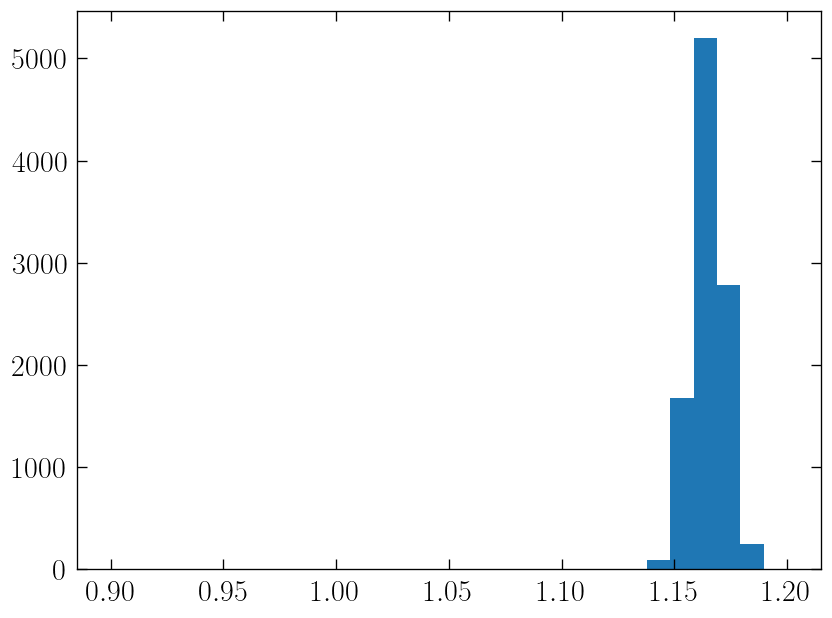

In [18]:
plt.figure(dpi = 120)
plt.hist(excessPers, bins = np.linspace(0.9, 1.2, 30))
plt.show()

In [19]:
includeInds = np.full(len(areaPix[0]), False, dtype = bool)
includeInds[0:int((float(samplePer)*len(includeInds)) / 100)] = True

np.random.shuffle(includeInds)
cropDetOfInterest = detOfInterest[includeInds]

areaAve = np.average(detOfInterest)
cropAve = np.average(cropDetOfInterest)

while (np.abs(areaAve - cropAve) / areaAve) > 0.001:
    np.random.shuffle(includeInds)
    cropDetOfInterest = detOfInterest[includeInds]
    cropAve = np.average(cropDetOfInterest)

In [20]:
newDetOfInterest = np.hstack((cropDetOfInterest,) * 2)

In [21]:
bootExcessPers = []
includeInds = np.full(len(newDetOfInterest), False, dtype = bool)
includeInds[0:int((float(samplePer)*len(includeInds)) / 100)] = True

for _ in range(10000):
    np.random.shuffle(includeInds)
    bootExcessPers.append(np.average(newDetOfInterest[includeInds]) / ave)

In [22]:
pureBootPers = []

for _ in range(10000):
    includeInds = np.random.randint(0, high = len(cropDetOfInterest), size = len(cropDetOfInterest))
    pureBootPers.append(np.average(cropDetOfInterest[includeInds]) / ave)

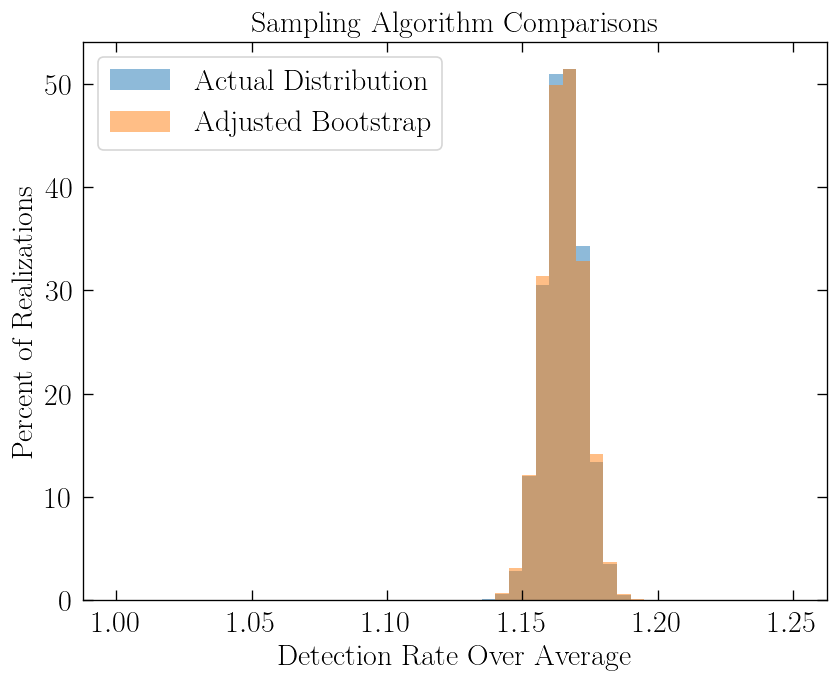

In [26]:
plt.figure(dpi = 120)
plt.hist(excessPers, bins = np.linspace(1, 1.25, 51), alpha = 0.5, label = 'Actual Distribution', density = True)
plt.hist(bootExcessPers, bins = np.linspace(1, 1.25, 51), alpha = 0.5, label = 'Adjusted Bootstrap', density = True)
# plt.hist(pureBootPers, bins = np.linspace(1.1, 1.225, 31), alpha = 0.5, label = 'Pure Bootstrap', density = True)
plt.xlabel('Detection Rate Over Average')
plt.ylabel('Percent of Realizations')
plt.title('Sampling Algorithm Comparisons')
plt.legend()
plt.show()

In [24]:
print(np.std(excessPers))
print(np.std(bootExcessPers))
print(np.std(pureBootPers))
print(np.abs(np.std(bootExcessPers) - np.std(excessPers)) / np.std(excessPers))

0.007206311668846851
0.007347601465797614
0.010235150743853713
0.01960639553817294


# End of Test

In [25]:
ave = np.average(origAllDetPixCounts)
testPix = []

for i in np.arange(numAreas):
    pixOfInterest = np.isin(origAllDetPix, areaPix[i])
    detOfInterest = origAllDetPixCounts[pixOfInterest]
    areaAve = np.average(detOfInterest)
    
    includeInds = np.full(len(detOfInterest), False, dtype = bool)
    includeInds[0:int((float(20)*len(includeInds)) / 100)] = True

    np.random.shuffle(includeInds)
    cropDetOfInterest = detOfInterest[includeInds]

    cropAve = np.average(cropDetOfInterest)

    while (np.abs(areaAve - cropAve) / areaAve) > 0.001:
        np.random.shuffle(includeInds)
        cropDetOfInterest = detOfInterest[includeInds]
        cropAve = np.average(cropDetOfInterest)
        
    testPix.append(origAllDetPix[pixOfInterest][includeInds])

In [26]:
allTestPix = []
for i in np.arange(len(testPix)):
    allTestPix.extend(testPix[i])
allTestPix = np.array(allTestPix)

In [27]:
aveTest = np.average(origAllDetPixCounts[np.isin(origAllDetPix, allTestPix)])

In [28]:
writeFile = directory + 'Stars/Area_Errors/0.0_Percent_' + str(rMagCut[0]) + '_' + str(rMagCut[1]) + '.fits'

my_table = Table()

for i in np.arange(len(testPix)):
    cropDetOfInterest = origAllDetPixCounts[np.isin(origAllDetPix, testPix[i])]
    newDetOfInterest = np.hstack((cropDetOfInterest,) * 5)
    
    bootExcessPers = []
    includeInds = np.full(len(newDetOfInterest), False, dtype = bool)
    includeInds[0:int((float(20)*len(includeInds)) / 100)] = True

    for _ in range(10000):
        np.random.shuffle(includeInds)
        bootExcessPers.append(np.average(newDetOfInterest[includeInds]) / aveTest)
        
    bootExcessPers = np.array(bootExcessPers)
    
    my_table[str(i)] = bootExcessPers

my_table.write(writeFile, overwrite = True)

In [29]:
origCondFiles = []
for cond in conditions:
    origCondFiles.append('/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/BalrogTests/Test1/Conds/' + cond + '.fits')
origCondFiles = np.array(origCondFiles)

origCondMaps = []
newPixCrop = np.isin(oldValidPix, validPix)

# This loops over every condition file
for condFile in origCondFiles:
    condData = fitsio.read(condFile) # This reads in the data
    origCondMaps.append(condData['SIGNAL'][newPixCrop]) # Only stores the values that are in pixels with injections

origCondMaps = np.array(origCondMaps)

In [30]:
persToUse = np.linspace(100, 20, 5)

## This Part Still Needs Work

In [31]:
allPixFile = strConfig.detStarAllPosFile

origInjData = fitsio.read(allPixFile)

origInjPix = origInjData['PIXEL']
origValidPix = np.unique(origInjPix)
origInjPix = origInjPix[~np.isin(origInjPix, allTestPix)]

origInjPix = np.sort(origInjPix)

# Everything from here until the main loop is to generate matchInds.
# These are only necessary in the train data where crops are made.

origInjPixUnique, origInjPixCounts = np.unique(origInjPix, return_counts = True)

trainOrigDetPix = origDetPix[~np.isin(origDetPix, allTestPix)]
matchInds = np.zeros(len(trainOrigDetPix), dtype = int)

startInjInds = np.append(np.array([0]), np.cumsum(origInjPixCounts)[:-1])

trainOrigAllDetPixCounts = origAllDetPixCounts[~np.isin(origAllDetPix, allTestPix)]
# origAllDetPix counts needs this continuous crop since it wasn't cropped immediately
startDetInds = np.append(np.array([0]), np.cumsum(trainOrigAllDetPixCounts)[:-1])

for i in np.arange(len(trainOrigAllDetPixCounts)):
    if trainOrigAllDetPixCounts[i] == 0:
        continue
    matchInds[startDetInds[i]: startDetInds[i] + trainOrigAllDetPixCounts[i]] = np.arange(trainOrigAllDetPixCounts[i]).astype(int) + startInjInds[i]
    
# STILL NEEDS WORK FROM HERE ON
for perObjectsToUse in persToUse:
    
    includeInds = np.full(len(origInjPix), False, dtype = bool)
    includeInds[0:int((float(perObjectsToUse)*len(includeInds)) / 100)] = True
    np.random.shuffle(includeInds)
    
    detPix = trainOrigDetPix[includeInds[matchInds]]
    injPix = origInjPix[includeInds]
    
    detPix = np.append(detPix, origDetPix[np.isin(origDetPix, allTestPix)])
    injPix = np.append(injPix, allTestPix)

    validPix =  np.unique(injPix)
    
    condCrop = np.isin(origValidPix, validPix)
    
    detPixIndicator, origDetPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
    origDetPixCounts = origDetPixCounts - 1
    
    condMaps = []

    # This loops over every condition file
    for origCondMap in origCondMaps:
        condMaps.append(origCondMap[condCrop]) # Only stores the values that are in pixels with injections

    condMaps = np.array(condMaps)
    
    trainInds = ~np.isin(detPixIndicator, allTestPix)
    
    aveDetTrain = np.average(origDetPixCounts[trainInds])

    sortInds = []
    for i in range(len(condMaps)):
        sortInds.append(condMaps[i][trainInds].argsort())
    sortInds = np.array(sortInds)
    
    binIndLims = [0]

    for j in range(binNum):
        binIndLims.append(int((np.sum(trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
        
    xBins = []

    for i in range(len(condMaps)):
        cond_Map_Sort = condMaps[i][trainInds][sortInds[i][::1]]
        condBins = []
        for j in range(binNum):
            condBins.append(cond_Map_Sort[binIndLims[j]:binIndLims[j+1]])
        indXBin = []

        for j in range(binNum):
            indXBin.append(np.average(condBins[j]))

        xBins.append(np.array(indXBin))

    xBins = np.array(xBins)
    
    yBinsOrig = []
    for i in range(len(condMaps)):
        detSort = origDetPixCounts[trainInds][sortInds[i][::1]]
        detBins = []
        for j in range(binNum):
            detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
        indYBinOrig = []

        for j in range(binNum):
            indYBinOrig.append(np.average(detBins[j]) / aveDetTrain)

        yBinsOrig.append(np.array(indYBinOrig))

    yBinsOrig = np.array(yBinsOrig)
    
    detPixCounts = np.copy(origDetPixCounts)
    
    allErrors = []

    while(True):

        yBins = []
        for i in range(len(condMaps)):
            detSort = detPixCounts[trainInds][sortInds[i][::1]]
            detBins = []
            for j in range(binNum):
                detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
            indYBin = []

            for j in range(binNum):
                indYBin.append(np.average(detBins[j]) / aveDetTrain)

            yBins.append(np.array(indYBin))

        yBins = np.array(yBins)

        index, maxErr = mostSigInd(yBins)
        if index == -1:
            break

        allErrors.append(maxErr)

        corrFunc = inter.interp1d(xBins[index], yBins[index], bounds_error = False, fill_value = (yBins[index][0], yBins[index][-1]))

        detPixCounts = detPixCounts / (corrFunc(condMaps[index]))

        detPixCounts = detPixCounts * aveDetTrain / (np.average(detPixCounts[trainInds]))
    
    aveDetTest = np.average(detPixCounts[~trainInds])
    
    writeFile = directory + 'Stars/Area_Errors/' + str(perObjectsToUse) + '_Percent_' + str(rMagCut[0]) + '_' + str(rMagCut[1]) + '.fits'
    my_table = Table()
    
    for i in np.arange(len(testPix)):
        
        cropDetOfInterest = detPixCounts[np.isin(detPixIndicator, testPix[i])]
        newDetOfInterest = np.hstack((cropDetOfInterest,) * 5)

        bootExcessPers = []
        includeInds = np.full(len(newDetOfInterest), False, dtype = bool)
        includeInds[0:int((float(20)*len(includeInds)) / 100)] = True

        for _ in range(10000):
            np.random.shuffle(includeInds)
            bootExcessPers.append(np.average(newDetOfInterest[includeInds]) / aveDetTest)

        bootExcessPers = np.array(bootExcessPers)

        my_table[str(i)] = bootExcessPers
        
        if i == 0:
            print(str(round(perObjectsToUse / 100, 3)) + ': ' + str(np.average(bootExcessPers)))
        else:
            print(str(np.average(bootExcessPers)))
        
    my_table.write(writeFile, overwrite = True)

KeyboardInterrupt: 

In [9]:
results = []

for i in np.linspace(0, 100, 6):
    readFile = directory + 'Stars/Area_Errors/' + str(i) + '_Percent_' + str(rMagCut[0]) + '_' + str(rMagCut[1]) + '.fits'
    results.append(fitsio.read(readFile))

In [15]:
for i in range(len(results)):
    indResult = results[i]['0']
    print(np.average(indResult))

1.142482217521816
0.9482621490946118
0.9776844715390207
0.9785812347518489
0.9776680861479892
0.9854506521553161


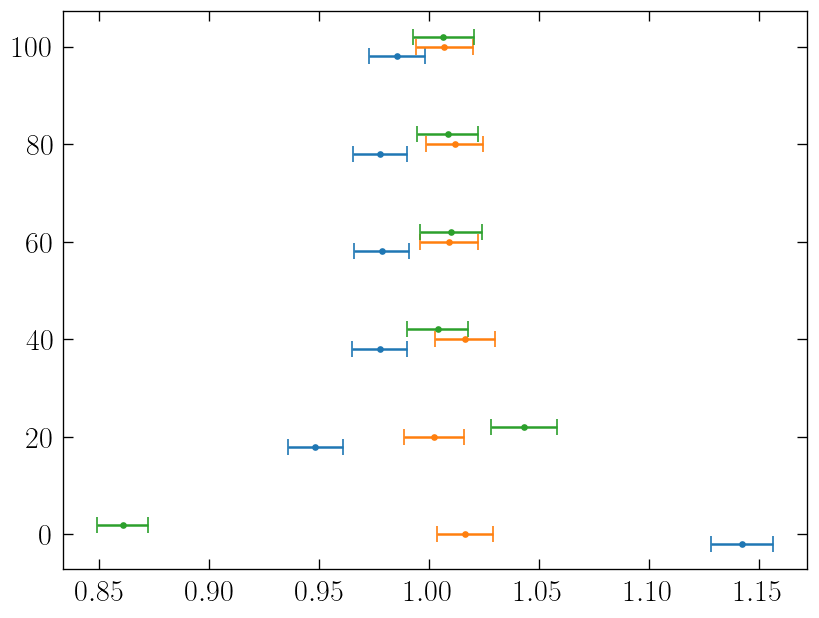

In [32]:
cmap = plt.get_cmap("tab10")
persUsed = np.linspace(0, 100, 6)
plt.figure(dpi = 120)
for i in np.arange(numAreas):
    for j in np.arange(len(persUsed)):
        plt.errorbar(np.average(results[j][str(i)]), persUsed[j] + (i - 1) * 2, xerr = np.std(results[j][str(i)]), color = cmap(i), capsize = 5, fmt = 'o', ms = 3.)
plt.show()